# D(St)reams of Anomalies

The main idea of this project is to graphically represent the anomalies or outliers and show how they change the orientation of the dataset.

What is an outlier?

An outlier is a data point in a data set that is distant from all other observations. A data point that lies outside the overall distribution of the dataset.

What are the criteria to identify an outlier?

Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile Data point that falls outside of 3 standard deviations. we can use a z score and if the z score falls outside of 2 standard deviation

What is the reason for an outlier to exists in a dataset?

Variability in the data An experimental measurement error

What are the impacts of having outliers in a dataset?

It causes various problems during our statistical analysis It may cause a significant impact on the mean and the standard deviation

# Features

We have taken the Twitter_volume_FB dataset. It has two columns - timestamp and value.

attributes - timestamp decision - value

# 1. Gathering necessary libraries

In [1]:
#Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# 2. Gathering the data

In [2]:
#Reading the csv files into dataframes
df = pd.read_csv('../datasets/Twitter_volume_FB.csv', encoding='utf-8')

In [3]:
#Printing out the first 5 columns of df1 dataframe.
df.head()

,timestamp,value
0,2015-02-26 21:42:53,53
1,2015-02-26 21:47:53,64
2,2015-02-26 21:52:53,49
3,2015-02-26 21:57:53,48
4,2015-02-26 22:02:53,22


Lets check if there is any missing data in the dataset.

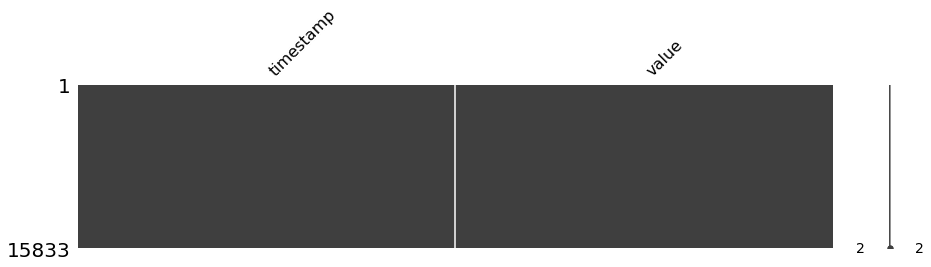

In [4]:
msno.matrix(df, figsize=(15, 3));

# 3. Some knowledge on the data

In [5]:
#To know the data types of the features in the dataset
df.dtypes

timestamp    object
value         int64
dtype: object

We need to convert the timestamp from object type to date time format.

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp    datetime64[ns]
value                 int64
dtype: object

In [7]:
#To know the number of rows and columns in a dataframe
df.shape

(15833, 2)

In [8]:
#Description of a dataframe
df.describe()

,value
count,15833.000000
mean,17.811280
std,19.740055
min,0.000000
25%,9.000000
50%,14.000000
75%,22.000000
max,1258.000000


The above table is very important in analyzing the anamolies. We use this in understanding the inter quartile ranges which we will discuss in this notebook.

# 4. Plots and Analysis

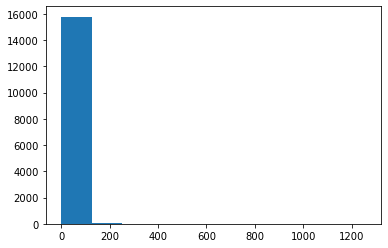

In [9]:
plt.hist(df['value'])
plt.show()

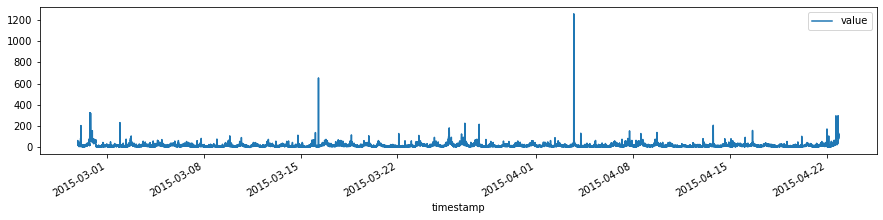

In [10]:
df.plot(x='timestamp', y='value', figsize=(15, 3));

<AxesSubplot:ylabel='value'>

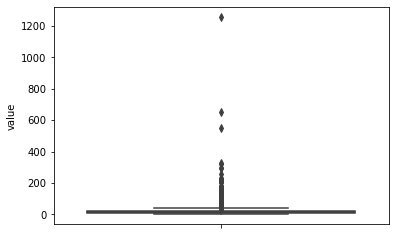

In [11]:
# Generate a Boxplot
sns.boxplot(y='value',data=df)

In [12]:
print('Minimum value ' + str(df['value'].min()))
print('Maximum value ' + str(df['value'].max()))

Minimum value 0
Maximum value 1258


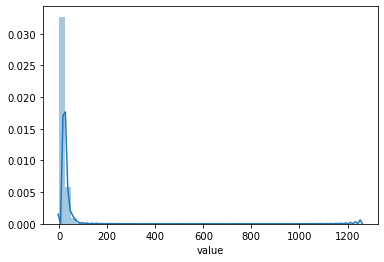

In [13]:
sns.distplot(df['value']);

# Adding month and hour features from the timestamp feature to the dataset

In [14]:
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

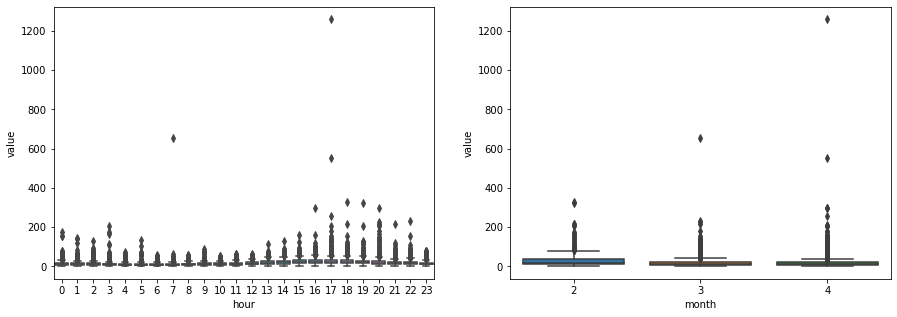

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(x="hour", y="value", data=df, ax=ax[0])
sns.boxplot(x="month", y="value", data=df, ax=ax[1]);

Analysis: From the histogram, it is very clear that the concentration of the values is around 10-80. There is a small concentration from 100-200. We can consider that as outliers.

In [16]:
#Dropping timestamp feature
X = df.drop('timestamp', axis=1)
X.head()

,value,month,hour
0,53,2,21
1,64,2,21
2,49,2,21
3,48,2,21
4,22,2,22


In [17]:
#Defining the lower and upper bounds
lower_bound = 0.1
upper_bound = 0.95

In [18]:
res =  df['value'].quantile([lower_bound,upper_bound])
res

0.10     6.0
0.95    41.0
Name: value, dtype: float64


We have defined the lower and upper bounds for the quantile.

So now the quantile has decided that

-any value < 6 is an outlier and -any value >41 is an outlier.

Case1 : Is 6 < 53 and Is 53 < 41 ? - False. So 53 is an outlier.

Case4 : Is 6 < 22 and Is 22 < 41 ? - True. So 22 is not an outlier.

It is as simple as that.

In [19]:
true_index = (res.loc[lower_bound] < df['value'].values) & (df['value'].values < res.loc[upper_bound])

In [20]:
true_index[:10]

array([False, False, False, False,  True,  True,  True,  True,  True,
        True])

In [21]:
df['value'][true_index][:20]

4     22
5     23
6     17
7     35
8     23
9     39
10    26
11    33
14    34
15    38
18    39
19    40
20    24
21    36
22    18
23    25
24    21
25    13
26     7
27    18
Name: value, dtype: int64

The above approach is used when there is not much information present in the outliers and when we decided to drop them from the datasets.

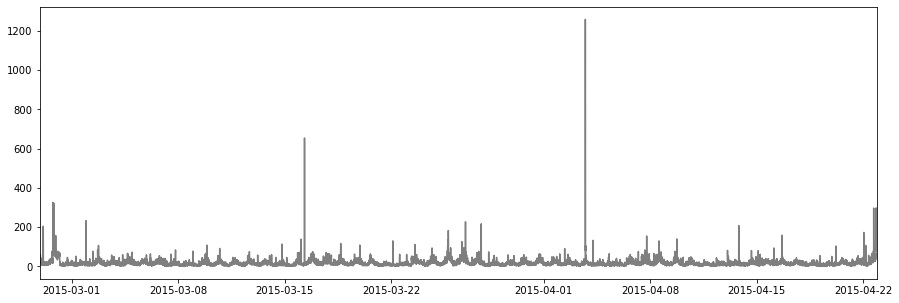

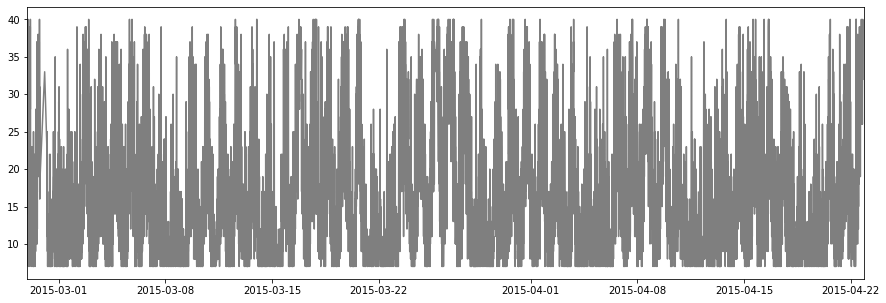

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
#plt.scatter(df[df['anomaly']==-1]['timestamp'], df[df['anomaly']==-1]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'][true_index], df['value'][true_index], c='k', alpha=0.5)
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

Look at the above two graphs.

The graph is the earlier graph with anomalies.

The second graph is when the anomalies are removed.

# 5. Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest

model =  IsolationForest(contamination=0.05, behaviour='new')
model.fit(X)

c:\users\vemulapalli likitha\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', contamination=0.05)

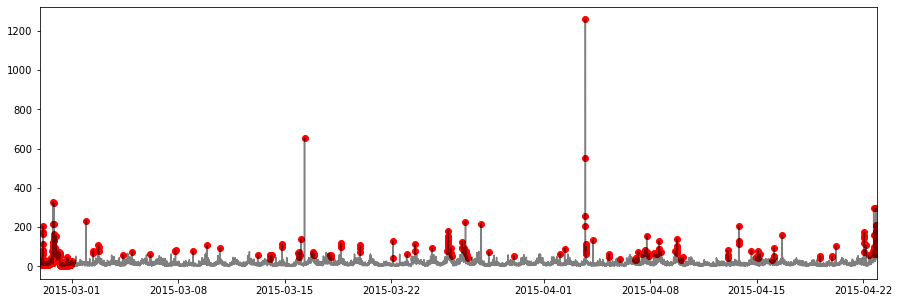

In [24]:
df['anomaly'] = model.predict(X)
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==-1]['timestamp'], df[df['anomaly']==-1]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

The red spots are the anomalies.

# 6. KMeans

A simple approach that we can use to detect outliers is through the K-Means method. Here, we are going to assing a cluster to each point in the data set. Firstly, it's necessary to choose the number of clusters. For this purpose, we can make use of the Elbow Method.

In [25]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(X) for i in n_cluster]
scores = [kmeans[i].score(X) for i in range(len(kmeans))]

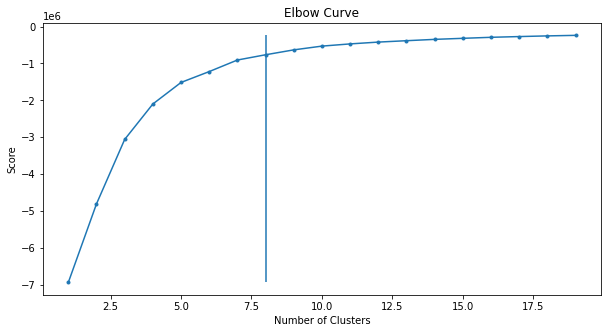

In [26]:
plt.figure(figsize=(10,5))
plt.plot(n_cluster, scores, marker='.')
plt.vlines(8, min(scores), max(scores))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [27]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
cluster = kmeans.predict(X);

In [28]:
import pandas as pd

def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance


outliers_fraction = 0.05
distance = getDistanceByPoint(X, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly'] = (distance >= threshold).astype(int)
df['cluster'] = cluster

c:\users\vemulapalli likitha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


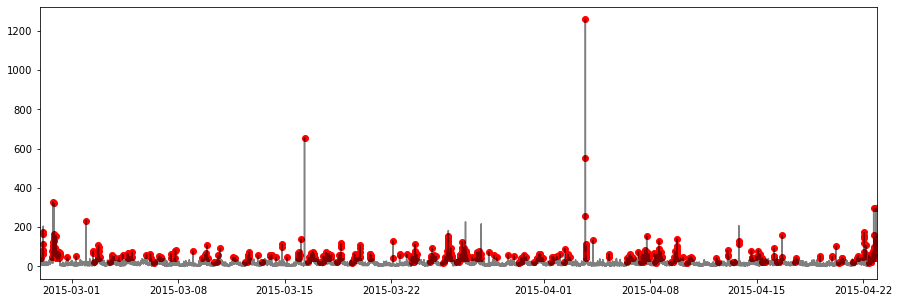

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['anomaly']==True]['timestamp'], df[df['anomaly']==True]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

In the following he have the detected outliers presented in red. From visual inspection, this strategy seems to be performing poorly. As we can see, most of the outliers are grouped in the same date range.

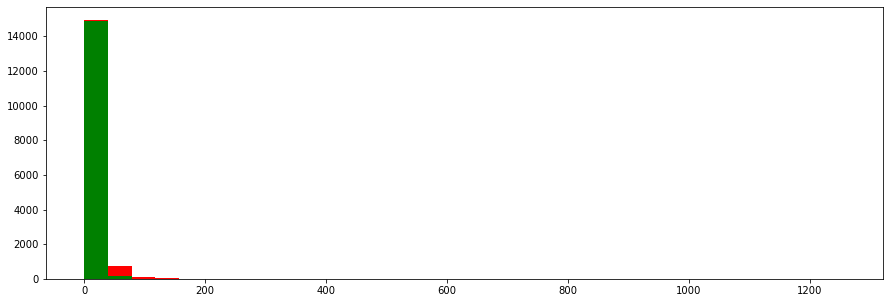

In [30]:
a = df.loc[df['anomaly'] != True, 'value']
b = df.loc[df['anomaly'] == True, 'value']

plt.figure(figsize=(15, 5))
plt.hist([a,b], bins=32, stacked=True, color=['green', 'red'], label=['normal', 'anomaly']);

The data is mostly concentrated in green region and the red are outliers.

# 7. DBSCAN

In [31]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1)
clusters = model.fit_predict(X)

In [32]:
df['cluster'] = clusters

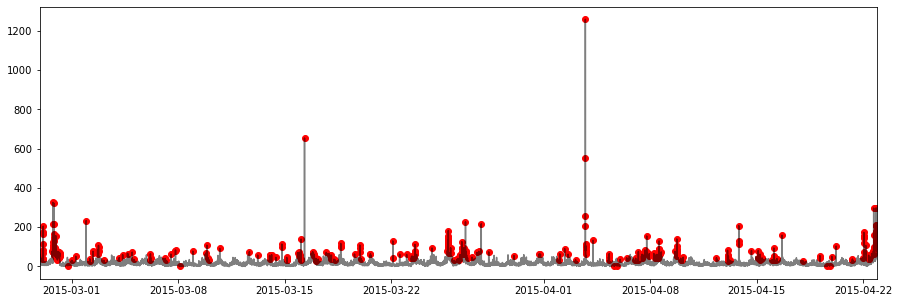

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], c='k', alpha=0.5)
plt.scatter(df[df['cluster']==-1]['timestamp'], df[df['cluster']==-1]['value'], c='red')
plt.xlim((df['timestamp'].min(), df['timestamp'].max()));

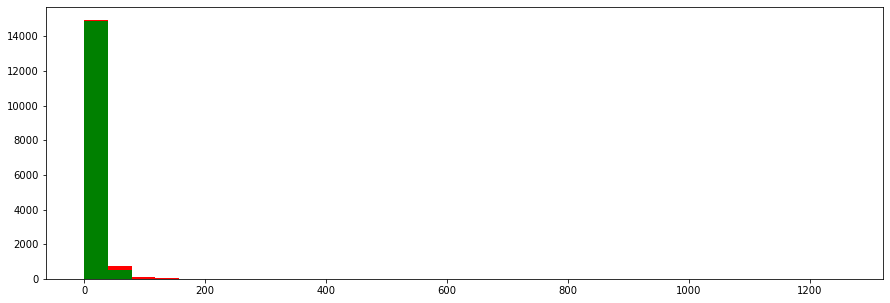

In [34]:
a = df.loc[df['cluster'] != -1, 'value']
b = df.loc[df['cluster'] == -1, 'value']

plt.figure(figsize=(15, 5))
plt.hist([a,b], bins=32, stacked=True, color=['green', 'red'], label=['normal', 'anomaly']);

The data is mostly concentrated in green region and the red are outliers.

# 8. Conclusion

# Where anomalies are used?

Payment Processor Companies (like PayPal) do keep a track of your usage pattern so as to notify in case of any dramatic change in the usage pattern. The patterns include transaction amounts, the location of transactions and so on. If a credit card is stolen, it is very likely that the transactions may vary largely from the usual ones. This is where (among many other instances) the companies use the concepts of anomalies to detect the unusual transactions that may take place after the credit card theft.